In [132]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display   #for loading and visualizing audio files
import IPython.display as ipd   #to play audio

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import time 
import pickle

# PCA

In [25]:
from sklearn.decomposition import PCA

Create function:
1. Which takes the numpy arrays containing y for each track_id. 
2. calculate DB for each track_id
3. ravel each DB into a numpy array
4. Once collected all, PCA into certain number of components.
5. Collect PCA components in dataframe and model on this

In [ ]:
df_PCA = pd.DataFrame(pca.transform(demo_noage), columns=[f'PC_{i+1}' for i in range(pca.n_components_)])
demo_pcs

In [89]:
a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/050993.npy', "rb")
ATS_050993 = np.load(a_array)

In [90]:
ATS_050993.shape

(661248,)

In [91]:
DB = librosa.amplitude_to_db(np.abs(librosa.stft(y = ATS_050993)), ref=np.max) #extracting DB
DB_ravel = DB.ravel()

In [94]:
DB_ravel.shape

(1324300,)

In [1]:
ATS_0_50_fp = '/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50'
ATS_0_50 = os.listdir(ATS_0_50_fp)
ATS_0_50

In [149]:
track_id_list = []
stacked_array_list = []

DB_stacked = np.zeros(1324300)

for i, val in enumerate(ATS_0_50[0:10]):
    a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/{}'.format(val), "rb")
    ATS = np.load(a_array)
    ATS.resize((661500,),refcheck=False) #resizing ATS to be 661500
    DB = librosa.amplitude_to_db(np.abs(librosa.stft(y=ATS)), ref=np.max) #extracting DB
    DB_ravel = DB.ravel() #flattening DB

    track_id_list.append(val.split('.')[0])
    if i == 0:
        DB_stacked = DB_ravel
    else:
        DB_stacked = np.vstack((DB_stacked, DB_ravel))
        
    print(DB_stacked.shape)
    print("__________")
    
#track_id_list
np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked)

(1324300,)
__________
(2, 1324300)
__________
(3, 1324300)
__________
(4, 1324300)
__________
(5, 1324300)
__________
(6, 1324300)
__________
(7, 1324300)
__________
(8, 1324300)
__________
(9, 1324300)
__________
(10, 1324300)
__________


In [246]:
DB_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', "rb")
DB_stacked_0_50 = np.load(DB_fp)

In [250]:
DB_stacked_0_50

array([-80.      , -70.33023 , -62.184227, ..., -80.      , -80.      ,
       -80.      ], dtype=float32)

Use cleaned dataframe from method 1 to only stack non-duplicated track_id's and corresponding ATS. Also avoiding tracks that have been tagged with erroneous genres. 

Use df_classifier_0_100_spark.csv to reference extraction

In [4]:
df_classifier1_0_100 = pd.read_csv('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/final_dfs/df_classifier1_0_100_trim.csv',dtype = {'track_id':str, 'folder':str}, index_col=False) #loading csv
df_classifier1_0_100.drop(axis = 1, columns=['Unnamed: 0','level_0','index'],inplace =True)

In [199]:
df_classifier1_0_100.folder.unique()[0:51]

array(['000', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '040', '041', '042', '043', '044',
       '045', '046', '047', '048', '049', '050'], dtype=object)

In [200]:
df_ref = df_classifier1_0_100[['track_id','folder','genres_top','genres','genres_all']]

In [12]:
condition_0_50 = df_classifier1_0_100.folder.isin(df_classifier1_0_100.folder.unique()[0:51])

In [19]:
df_classifier1_0_100.genres_top.value_counts()

Rock            4483
Electronic      4343
Experimental    1448
Hip-Hop         1373
Folk             923
Pop              725
Classical        505
Instrumental     363
Jazz             343
Soul-RnB         113
Country          108
Blues             55
Name: genres_top, dtype: int64

In [34]:
115*11 + 55 

1320

In [16]:
df_classifier1_0_100[condition_0_50].genres_top.value_counts()

Rock            2268
Electronic      1933
Experimental     800
Hip-Hop          543
Folk             469
Pop              354
Classical        259
Jazz             200
Instrumental     141
Country           81
Soul-RnB          68
Blues             48
Name: genres_top, dtype: int64

Expect shape of ( < 1500, 1324300) from final DB_stacked_0_50

As stacking ATS numpyarrays will require a lot of RAM cannot stack all tracks and PCA on this need to select a partition of the data. Cannot randomly select otherwise will have major class imbalance with an already low amount of rows per genre (since only a partition).

Only extracting genres up until number of tracks with a certain genre reaches minimum quota. Continues collecting other track_ids with other genres until quota reached for given genre and so on. 

***EXTRACTING*** 

Getting DB stacked numpy array for track_ids in folders 0 - 50 and saving to hard drive (*Do not run twice*)

In [172]:
def check_genre(genre, ID):
    return df_ref[condition]['genres_top'].values[0] == genre
ID = '000002'
check_genre('Hip-Hop',ID)

In [2]:
ATS_0_50_fp = '/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50'
ATS_0_50 = os.listdir(ATS_0_50_fp)

track_id_list = []
track_id_notadded = []

DB_stacked = np.zeros(1324300)
count = 0
genre_list = ['Rock', 'Electronic', 'Experimental', 'Hip-Hop', 'Folk', 'Pop', 'Classical', 'Jazz', 'Instrumental', 
              'Country', 'Soul-RnB', 'Blues']
# ______ 
rock = 0
elec = 0
exp = 0
HH = 0
folk = 0
pop = 0
classical = 0
jazz = 0
instr = 0
country = 0
soul = 0
blues =0 
# ______

for i, val in enumerate(ATS_0_50):
    a_array = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/ATS_0_50/{}'.format(val), "rb")
    ATS = np.load(a_array)
    ATS.resize((661500,),refcheck=False)     #resizing ATS to be 661500
    DB = librosa.amplitude_to_db(np.abs(librosa.stft(y = ATS)), ref=np.max) #extracting DB
    DB_ravel = DB.ravel()     #flattening DB
    ID = str(val.split('.')[0])
    target = 115
    if ID in df_ref.track_id.values:
        condition = df_ref.track_id == ID
        if i == 0:
            DB_stacked = DB_ravel
            track_id_list.append(val.split('.')[0])            
        elif check_genre('Rock',ID) & (rock < target):
            rock = rock + 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Rock :', df_ref[condition].genres_top.values[0])
        elif check_genre('Electronic',ID) & (elec < target):
            elec += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Electronic :', df_ref[condition].genres_top.values[0])
        elif check_genre('Experimental',ID) & (exp < target):
            exp += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Experimental :', df_ref[condition].genres_top.values[0])
        elif check_genre('Hip-Hop',ID) & (HH < target):
            HH += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Hip-Hop :', df_ref[condition].genres_top.values[0])
        elif check_genre('Folk',ID) & (folk < target):
            folk += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))   
            #print('Folk :', df_ref[condition].genres_top.values[0])
        elif check_genre('Pop',ID) & (pop < target):
            pop += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Pop :', df_ref[condition].genres_top.values[0])
        elif check_genre('Classical',ID) & (classical < target):
            classical += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Classical :', df_ref[condition].genres_top.values[0])
        elif check_genre('Jazz',ID) & (jazz < target):
            jazz += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Jazz :', df_ref[condition].genres_top.values[0])
        elif check_genre('Instrumental',ID) & (instr < target):
            instr += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Instrumental :', df_ref[condition].genres_top.values[0])
        elif check_genre('Country',ID) & (country < target):
            country += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Country :', df_ref[condition].genres_top.values[0])
        elif check_genre('Soul-RnB',ID) & (soul < target):
            soul += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel)) 
            #print('Soul-RnB :', df_ref[condition].genres_top.values[0])
        elif check_genre('Blues',ID) & (blues < target):
            blues += 1
            track_id_list.append(val.split('.')[0])
            DB_stacked = np.vstack((DB_stacked, DB_ravel))
            #print('Blues :', df_ref[condition].genres_top.values[0])
        else:
            print("NONE :",df_ref[condition].genres_top.values[0])
            track_id_notadded.append(ID)
        print('track_id :', ID)
    else:
        pass
    count = count + 1
    print(i)
    if count == 100:
        np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked) 
        count = 0
np.save('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', DB_stacked)

track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "wb")
pickle.dump(track_id_list, track_id_fp)
track_id_fp.close()
#track_id_list.insert(0,'000139')

In [244]:
#condition = df_ref.track_id == ID
def get_genre(ID):
    condition = df_ref.track_id == ID
    return df_ref[condition]['genres_top'].values[0]

In [250]:
genre_list = []
for ID in track_id_list:
    genre_list.append(get_genre(ID))

### Saving track_id and genre list

In [277]:
'''
track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "wb")
pickle.dump(track_id_list, track_id_fp)
track_id_fp.close()

genre_list_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/genre_list.pkl', "wb")
pickle.dump(genre_list, genre_list_fp)
genre_list_fp.close()''';

### Loading track_id, genre lists and DB_stacked numpy array

In [2]:
track_id_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/track_id_list.pkl', "rb")
track_id_list = pickle.load(track_id_fp)

genre_list_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/genre_list.pkl', "rb")
genre_list = pickle.load(genre_list_fp)

DB_stack_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/DB_stacked_0_50.npy', "rb")
DB_stacked = np.load(DB_stack_fp)

Create DB_stacked dataframe from DB numpy array :

In [3]:
df_DB = pd.DataFrame(data = DB_stacked)

In [269]:
#df_DB.insert(0, 'track_id', track_id_list)
#df_DB.insert(1, 'genre_top', genre_list)
#df_DB.head()
#df_DB_raw = df_DB.drop(columns = ['track_id','genre_top'])

Applying PCA 

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
pca.fit(df_DB)

PCA(n_components=1000)

In [6]:
df_DB_pca = pd.DataFrame(pca.transform(df_DB), columns=[f'PC_{i+1}' for i in range(pca.n_components_)])

In [7]:
df_DB_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_991,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,PC_1000
0,10078.040039,306.597321,-3034.967773,806.417053,13.430355,808.089050,-414.565552,-127.220505,-1343.913452,69.132774,...,1.852397,8.823978,48.225185,-32.082897,140.478104,56.710449,19.255308,-46.259407,49.222427,-43.808361
1,-6403.381348,-4613.407715,-3237.626221,-107.894600,991.465210,-990.849182,1800.114258,1102.489380,-1269.643188,209.162308,...,-67.657242,-487.661316,34.751194,-235.312714,254.310287,-162.107468,-192.955566,185.439606,-161.606705,146.136658
2,-7731.916992,-1018.027344,-8754.224609,816.567688,1607.343018,1082.048706,-1097.193604,-1831.873169,-1789.753784,-168.600204,...,-108.332344,-0.715170,121.278961,-204.109909,48.674000,44.526928,-120.469177,-57.844471,-84.828087,220.603638
3,7504.065430,3512.296387,-259.968964,-768.068542,1485.589355,-488.783478,2508.389404,-1033.721069,-1597.895874,174.100449,...,-578.482300,118.543877,361.266205,-42.397144,45.313126,-492.610931,-186.842224,648.584900,-391.695404,-392.097137
4,9588.051758,4207.545898,256.408966,2822.379639,-101.647354,-1707.434937,-1134.129028,-469.481415,1970.599731,-470.494781,...,106.800850,-7.794832,117.390495,168.896835,149.696198,67.292862,7.928970,-62.200504,-218.686752,-209.174301


Saving / Loading DB PCA dataframe :

In [30]:
'''df_DB_pca_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/df_DB_pca.csv', "wb")
pickle.dump(df_DB_pca, df_DB_pca_fp )
df_DB_pca_fp.close()''';

df_DB_pca_fp = open('/Volumes/Extreme SSD/CAPSTONE_DATA/saved/PCA/df_DB_pca.csv', "rb")
df_DB_pca = pickle.load(df_DB_pca_fp)

By including all PCA components (1000) we can explain 97% of the variance

In [12]:
pca.explained_variance_ratio_.cumsum()[-1]

0.97029936

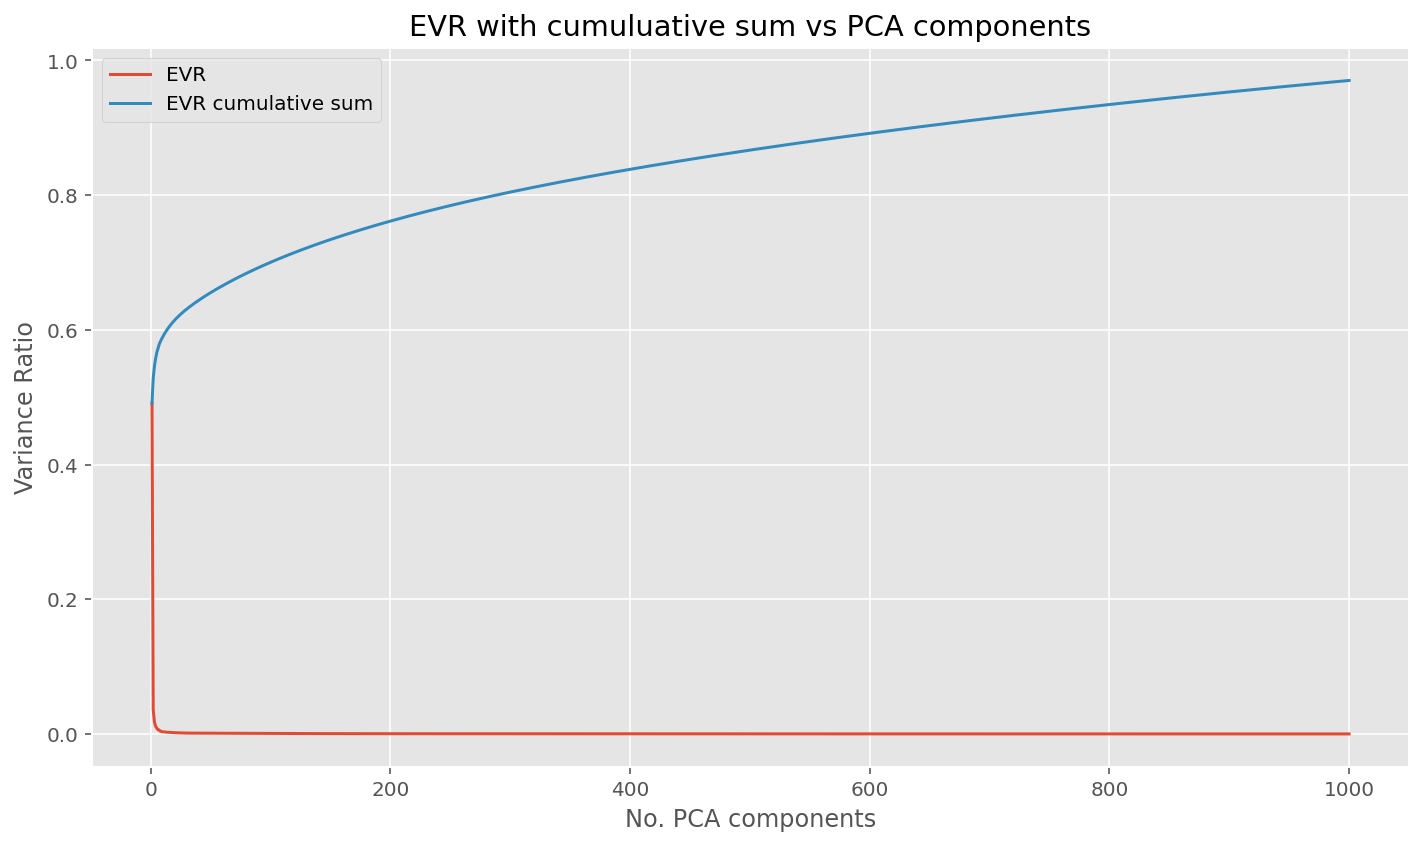

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.lineplot(x = range(1, pca.n_components_+1),y = pca.explained_variance_ratio_, ax=ax)
sns.lineplot(x = range(1, pca.n_components_+1),y = pca.explained_variance_ratio_.cumsum(), ax=ax)

#ax.set_xticklabels(labels = x, rotation = 30)  
ax.legend(labels=["EVR","EVR cumulative sum"])
ax.set_ylabel("Variance Ratio")
ax.set_xlabel("No. PCA components")
ax.set_title("EVR with cumuluative sum vs PCA components")
fig.tight_layout()
plt.show()

In [32]:
from scikitplot.decomposition import plot_pca_2d_projection

In [ ]:
plot_pca_2d_projection(pca, df_DB, df_DB.index, 
                       biplot=True,  
                       feature_labels=demo_noage.columns.to_list(), 
                       figsize=(12, 6))
plt.legend(loc=[1.1, 0], fontsize=8, ncol=3)
plt.show()